In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [77]:
#====Physical Parameters====
#Temperature (K)
T = 25+273
    
#====Cathode Materials Physical Parameters====
#Molar Volume (m3/mol) [S8, Li2S8, Li2S4, Li2S2, Li2S]
V_i = np.array([1.239e-4, 1.361e-4, 7.415e-5, 4.317e-5, 2.768e-5])
    
#Material Density (kg/m3)
rho_carbon_true = 2000 
rho_carbon_bulk = 120 #Typical of high porosity Ketjen black
    
    #Porosity of carbon support
eps_void_carbon = 1 - rho_carbon_bulk/rho_carbon_true
#eps_carbon = 1 - eps_void_carbon
    
    #====Electrolyte Physical Parameters====
    #Species charge [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
z_i = np.array([0, -2, -2, -2, -2, -2, -1])
    
    #Species Diffusivity (m2/s) [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
D_i = np.array([1e-10, 1e-9, 6e-10, 6e-10, 1e-10, 1e-10, 1e-10, 4e-10])
    
    #====Initial Cathode Dry Composition====
w_S = 0.4 #Mass Fraction Sulfur 
mg_S_cm2 = 1 #Areal Mass Loading Sulfur (mg/cm2)
m_S = mg_S_cm2/10**6*100**2 #Areal sulfur mass loading (kg/m2)
    #Mass Fraction [S8, C]
w_i = np.array([w_S, 1 - w_S])
    #Molar mass (kg/mol)
M_i = np.array([0.25648, 0.012011])
    #Moles at 1kg basis (mol)
n_i_dry = w_i/M_i
    #Molar volumes (m3/mol) 
V_S_n = 1.239e-4
V_C_n_bulk = M_i[1]/rho_carbon_bulk
V_C_n_true = M_i[1]/rho_carbon_true
    #Volumes at 1 kg basis (m3)
V_S = V_S_n*n_i_dry[0]
V_C_bulk = V_C_n_bulk*n_i_dry[1]
V_C_true = V_C_n_true*n_i_dry[1]
V_void_C = V_C_bulk*eps_void_carbon
V_void_cat = V_void_C - V_S
    #Initial Volume Fraction of Sulfur
eps_S_init = V_S/V_C_bulk #Approximate. Valid until ~95% Sulfur loading.
eps_carbon = V_C_true/V_C_bulk
    
    #====Reaction Parameters====
    #Butler-Volmer Parameters
i_o_i = np.array([0.394, 1.972, 0.019, 0.019, 1.97e-4, 1.97e-4])
alpha = 0.5
n_elec = 1
U_half = np.array([0.0, 2.39, 2.37, 2.24, 2.04, 2.01])
    
    #Precipitation Parameters [S8, Li2S8, Li2S4, Li2S2, Li2S]
k_precip = np.array([1, 1e-4, 9.98e-5, 9.98e-5, 27.5])
K_sol = np.array([19, 38.09, 11.26, 5.1e-3, 3.0e-5])
C_i_k_ref = np.array([1/V_S_n, 1e-20, 1e-20, 1e-20, 1e-20])
    
    #====Initial Conditions====
    #Reference (Initial) Concentrations (mol/m3) [Li^+, S8, S8^2-, S6^2-, S4^2-, S2^2-, S^2-, A^-]
C_i_l_ref = np.array([1001.0440010474534, 19.0, 0.178, 0.324, 0.020, 5.229e-7, 8.267e-10, 1000.0])
    
    #Initial Liquid Porosity
eps_elyte_sep_init = 0.39 #separator
eps_elyte_cat_init = V_void_cat/V_C_bulk #cathode (Assuming negligible sulfur contribution to cathode volume)
    
    #Bruggeman Correlation
b_sep = -0.5
b_cat = -0.5
b_carbon = -0.5
tau_elyte_sep_init = eps_elyte_sep_init**b_sep
tau_elyte_cat_init = eps_elyte_cat_init**b_cat
tau_carbon = eps_carbon**b_carbon
    
    #Initial Volume Fractions [S8, Li2S8, Li2S4, Li2S2, Li2S]
eps_i_cat_init = np.array([eps_S_init, 1e-6, 1e-6, 1e-6, 1e-7])
eps_i_sep_init = np.array([1e-12, 1e-6, 1e-6, 1e-6, 1e-7])
    
    #Initial Cathode Surface Area (m2/m3)
a_init = 1270.*rho_carbon_bulk*(eps_elyte_cat_init/eps_void_carbon)**1.5
xi = 1.5

#Cathode Electronic Conductivity
sigma_C_pure = 1.28e5 #S/m
sigma_C_eff = eps_carbon/tau_carbon*sigma_C_pure

#Cathode Thickness (m)
l_cat = V_S_n/M_i[0]*m_S/eps_S_init

#Separator Thickness (m)
l_sep = 25e-6

#Cell Thickness (m)
l_cell = l_cat + l_sep

#x-discretization
nodes = 100
x = np.linspace(0, l_cell, nodes+1)
dx = l_cell/nodes

sep_cat_node = int(round(l_sep/dx))

#Cutoff Voltage (V)
V_cutoff = 1.5

#Applied Current Density
Q_theo = 1675 #Ah/kg_S
C_rate_1 = Q_theo #A/kg_S
C_rate = 0.1 #Applied C-rate
applied_current = C_rate*C_rate_1*m_S #A/m2

print(nodes)

100


In [3]:
#Initialize ionic species concentration array
C_i = np.zeros((8, len(x)))

#Populate initial conditions
for i in range(8):
    C_i[i] = C_i_l_ref[i]
    

In [4]:
#Initialize electrolyte porosity array
eps_elyte = np.zeros(len(x))

#Populate initial conditions
for i in range(nodes+1):
    if x[i] < l_sep:
        eps_elyte[i] = eps_elyte_sep_init
    else:
        eps_elyte[i] = eps_elyte_cat_init
     

In [5]:
#Initialize solid volume fraction array
eps_k = np.zeros((5, len(x)))

#Populate initial conditions
for i in range(5):
    for j in range(nodes+1):
        if x[j] < l_sep:
            eps_k[i,j] = eps_i_sep_init[i]
        else:
            eps_k[i,j] = eps_i_cat_init[i]
            

In [34]:
#Initialize current array with initial guesses and boundary conditions
##Row 0 -> solid phase
##Row 1 -> electrolyte phase
current = applied_current*np.ones((2, len(x)))
current[0, :-1] = current[1,-1:] = 0


[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    1.675]
 [1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675
  1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675
  1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675
  1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675
  1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675 1.675
  1.675 1.675 1.675 1.675 1.6

In [133]:
#Initialize potential array with initial guesses
##Row 0 -> solid phase
##Row 1 -> electrolyte phase
phi = np.ones((2, len(x)))
phi[:,0] = 0

print(phi)

[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1.]]


In [9]:
#Initialize surface area array with initial values (m2/m3)
a = np.ones(len(x))

for i in range(nodes+1):
    if x[i] > l_sep:
        a[i] = a_init
   

In [123]:
#Initialize faradaic current array (A/m2)

i_i = -0.05*np.ones(len(i_o_i))

print(i_i)

[-0.05 -0.05 -0.05 -0.05 -0.05 -0.05]


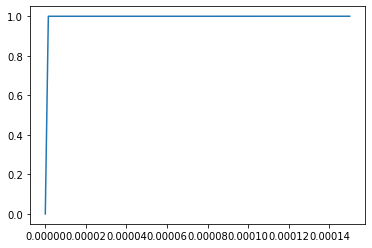

In [147]:
for k in range(1): #Iterate to converge on solution
    for i in range(2): #Loop through liquid and solid phase
        ####Separator Block
        for j in range(sep_cat_node+1): #Loop through separator location x
            
        
        
        ####Cathode Block
        for j in range(sep_cat_node+2, nodes+1): #Loop through cathode location x
            
            ##Current block
            #a[j] = a_init #Calculate the cathode surface area
            i_sum = 0 #Set faradaic current sum counter
            for k in range(4): #Loop through 5 cathodic faradaic reactions
                #i_i[k+1] = i_i[k+1] #Calculate faradaic current
                i_sum = i_sum + i_i[k+1] #Add to the current sum counter
            di_e_dx = a*i_sum #Electrolyte current derivative
            di_s_dx = -di_e_dx #Solid current derivative
            if i == 0: #Finite Difference Calculation
                current[i,j] = current[i,j-1] + di_s_dx[j]*dx
            else:
                current[i,j] = current[i,j-1] + di_e_dx[j]*dx
            
            ##Potential Block
            dphi_s_dx = -current[0]/sigma_C_eff #Solid potential derivative
            dphi_s_dx[-1] = applied_current/sigma_C_eff #Boundary Condition
            dphi_e_dx = (current[1] - 1)/-1 ##Electrolyte potential derivativeReplace ones with sumA and sumB
            dphi_e_dx[-1] = 0 #Boundary Condition
            if i == 0: #Finite Difference Calculation
                phi[i,j] = phi[i,j-1] + dphi_s_dx[j]*dx
            else:
                phi[i,j] = phi[i,j-1] + dphi_e_dx[j]*dx
#print(phi)  
#plt.plot(x,current[0])
#plt.plot(x,current[1])
#plt.plot(x,dphi_e_dx)
#plt.plot(x,dphi_s_dx)
#plt.plot(x,phi[0])
#plt.plot(x,phi[1])
#print(current)